# Bitbot

## Setup

### Jupyter

In [10]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Imports

In [11]:
#%%capture output
!{sys.executable} -m pip install ccxt yfinance git+https://github.com/donbing/mplfinance.git
import pandas as pd
import sys
import ccxt
import mplfinance as mpf
from matplotlib.pyplot import imshow
import yfinance
import pathlib
import os

  Cloning https://github.com/donbing/mplfinance.git to /tmp/pip-req-build-eh5m4bj3
  Running command git clone -q https://github.com/donbing/mplfinance.git /tmp/pip-req-build-eh5m4bj3
  Created wheel for mplfinance: filename=mplfinance-0.12.8b10-py3-none-any.whl size=70315 sha256=67e804d0b44683f411dfd767f464f100935e04358315f499cac5fff05103cbcf
  Stored in directory: /tmp/pip-ephem-wheel-cache-wu9dpgk9/wheels/7a/19/79/ca6b247407a3bdbf9008674616b262fd49f79b6324a5746057
Successfully built mplfinance


In [12]:
from src.bitbot import BitBot
from src.configuration.bitbot_files import use_config_dir
from src.configuration.bitbot_config import load_config_ini

### Load config files

In [13]:
curdir = pathlib.Path(os.path.abspath('')).resolve()
files = use_config_dir(curdir)
config = load_config_ini(files)
config.set('display', 'output', 'disk')
config.set('display', 'resolution', '400,300')

## Bitbot display output  

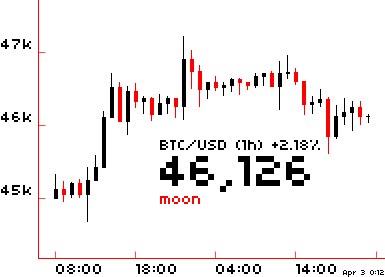

In [14]:
app = BitBot(config, files)
img  = app.display_chart()
img.show()

## Bitbot chart generation

In [15]:
# fetch configured candle history
from src.exchanges import crypto_exchanges
exchange = crypto_exchanges.Exchange(config)
chart_data = exchange.fetch_history()
chart_data

<BTC/USD 1d candle data>

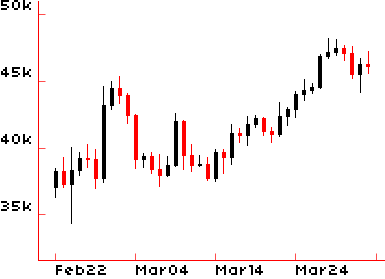

In [16]:

from src.drawing.mpf_plotted_chart import NewPlottedChart
from src.display.picker import picker as display_picker
import io
from PIL import Image

display = display_picker(config)
chart = NewPlottedChart(config, display, files, chart_data)
with io.BytesIO() as file_stream:
    chart.write_to_stream(file_stream)
    chart_image = Image.open(file_stream)
    chart_image.show()

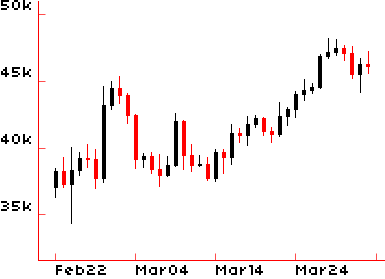

In [17]:
# plot chart and show image
from src.drawing.market_chart import MarketChart
from src.display.picker import picker as display_picker
from PIL import Image
import io

display = display_picker(config)
chart = MarketChart(config, display, files)

with io.BytesIO() as file_stream:
    chart.create_plot(chart_data).write_to_stream(file_stream)
    chart_image = Image.open(file_stream)
    chart_image.show()

## MPF plot

### Fetch Data

In [18]:
# load markets for selected exchange
exchange = getattr(ccxt, 'bitmex')()
mkts = exchange.loadMarkets()

In [19]:
# fetch candles
exchange_data = exchange.fetchOHLCV('BTC/USD', '5m', limit=40)
# convert candles to dataframe
df = pd.DataFrame(exchange_data)
df.columns = ["Date", "Open", "Low", "High", "Close", "Volume"]
df['Date'] = pd.to_datetime(df['Date'].astype('datetime64[ms]'))
#df.index = pd.DatetimeIndex(df["Date"].astype('datetime64[ms]'))
df.set_index('Date', inplace=True)
# df

### Try to draw an attractive graph

### 🛳️ imports

In [20]:
import matplotlib
from matplotlib  import pyplot as plt
from matplotlib.ticker import EngFormatter
matplotlib.use('Agg')
import numpy 
display_size = (400,300)

### ⏲️ select datetime format

In [21]:
candle_time_delta = df.index.values[1] - df.index.values[0]
if(candle_time_delta <= numpy.timedelta64(1,'h')):
    format = '%H:%M'
elif(candle_time_delta <= numpy.timedelta64(1,'D')): 
    format = '%b.%d'
else:
    format = '%b'

### 📐 mpf style

In [22]:
s = mpf.make_mpf_style(
    marketcolors=mpf.make_marketcolors(
        alpha=1.0,
        up='black', down='red',
        edge={'up': 'black', 'down': 'red'},  # 'none',
        wick={'up': 'black', 'down': 'red'},
        volume={'up': 'black', 'down': 'red'}
    ),
    base_mpl_style=[files.base_style, files.default_style],
    mavcolors=['#1f77b4', '#ff7f0e', '#2ca02c'],
    rc={}
)

### 📈 create plot figure

In [23]:
fig, ax = mpf.plot(
    df,
    scale_width_adjustment=dict(volume=0.9, candle=0.7, lines=0.05),
    update_width_config=dict(candle_linewidth=0.6),
    returnfig=True,
    type='candle',
    # mav=(10, 20),
    volume=False,
    style=s,
    tight_layout=True,
    figsize=tuple(dim/100 for dim in display_size),
    xrotation=0,
    datetime_format=format,
)

### 🪓 customise axes

In [24]:

for a in ax: 
    a.yaxis.set_major_formatter(EngFormatter(sep=''))
    a.autoscale(enable=True, axis="x", tight=True)
    a.autoscale(enable=True, axis="y", tight=True)
    a.margins(0.1, 0.2)
    _ = a.set_ylabel("")
    _ = a.set_xlabel("")

    # for label in a.yaxis.get_ticklabels():
    #     label.set_horizontalalignment('left')
        
    # for label in a.xaxis.get_ticklabels():
    #     label.set_verticalalignment('bottom')
    #a.tick_params(rotation = 45, ha='left')

### Output

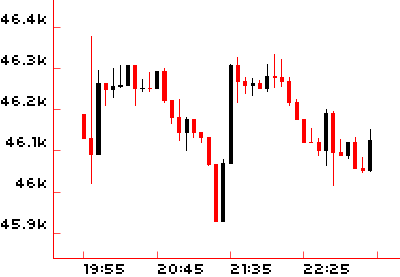

In [28]:
with io.BytesIO() as file_stream:
    fig.savefig(file_stream, dpi=fig.dpi, bbox_inches='tight', pad_inches=0.0)
    chart_image = Image.open(file_stream)
    chart_image.show()